In [83]:
# Project - Financial Data Analytics with Python
# Last Build date: 2022-8-15

# For debug use
import warnings
warnings.filterwarnings("ignore")

In [84]:
# Import required libraries
import datetime as dt
import pandas as pd
import numpy as np
# For download stock data
import yfinance as yf
# Prepare web scraping data from wikipedia
import bs4 as bs
import requests
# Prepare optimization
# Using efficient frontier and assigning weights (Optimization)
# Import required libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
#from pypfopt.cla import CLA
#from pypfopt import plotting
#from matplotlib.ticker import FuncFormatter
# Quantstats library for html report
import quantstats as qs

In [85]:
# User custom values

# Data Source: File / Web 
# File: Get data from file (Run faster, select this if no internet connection)
# Web: Download live data using yfinance library (Require internet connection, not fully tested)
source = 'File' # (File / Web)
# Market stocks: Dow Jones Industrial Average (DJI) / S&P 100 (S&P100)
# Build portfolio using the stocks in that market index
stock_index = 'DJI' # (DJI / S&P100)

# Portfolio options
# These are parameters to construct a new portfolio with optimization
# 1. Max Sharpe ratio
# 2. Min risk
# 3. Target risk
# 4. Target return

# Below is default one, feel free change to your values
start = dt.datetime(2019, 5, 1) # Back-test start date (must >= 2018-01-01)
end = dt.datetime(2022, 8, 31) # Back-test end date
capital = 10000 # Money will invest into portfolios
risk_free_rate = 0.02 # Risk free rate (%)
min_weight = 0.05 # Lower bound weighting used in optimization
max_weight = 1 # Upper bound weighting used in optimization
your_risk = 0 # Custom risk, useful if strategy = custom_risk
your_return = 0 # Custom return, useful if strategy = custom_return
strategy = 'max_sharpe' # (vaild options: max_sharpe / min_risk / custom_risk / custom_return)

In [86]:
# Get symbols from DJI wiki page
def get_DJI():
    if source == 'File':
        tickers = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WBA','WMT']
    else:
        #Web Scraping for the DJI Tickers
        resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class' : 'wikitable sortable'}) # table class name is wikitable sortable
        tickers = []
        for row in table.findAll('tr')[1:]:   #Table row
            ticker = row.findAll('td')[1].text.replace('\n','')   #Table data
            ticker = ticker.split(':\xa0')
            if len(ticker) > 1:
                tickers.append(ticker[1])
            else:
                tickers.append(ticker[0])
    return tickers

In [87]:
# Or get symbols from S&P100, if your favourite stocks not in DJI, you can use this ticker list
def get_sp100():
    if source == 'File':
        tickers = ['AAPL','ABBV','ABT','ACN','ADBE','AIG','AMGN','AMT','AMZN','AVGO','AXP','BA','BAC','BK','BKNG','BLK','BMY','BRK-B','C','CAT','CHTR','CL','CMCSA','COF','COP','COST','CRM','CSCO','CVS','CVX','DD','DHR','DIS','DOW','DUK','EMR','EXC','F','FDX','GD','GE','GILD','GM','GOOG','GOOGL','GS','HD','HON','IBM','INTC','JNJ','JPM','KHC','KO','LIN','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','META','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','PEP','PFE','PG','PM','PYPL','QCOM','RTX','SBUX','SCHW','SO','SPG','T','TGT','TMO','TMUS','TSLA','TXN','UNH','UNP','UPS','USB','V','VZ','WBA','WFC','WMT','XOM']
    else:
        # URL request, URL opener, read content
        resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class' : 'wikitable sortable'}) # table class name is wikitable sortable
        tickers = []
        for row in table.findAll('tr')[1:]:   #Table row
            ticker = row.findAll('td')[0].text.replace('\n','')   #Table data
            ticker = ticker.split(':\xa0')
            if len(ticker) > 1:
                tickers.append(ticker[1])
            else:
                tickers.append(ticker[0])
        tickers = list(map(lambda x: x.replace('.', '-'), tickers)) # For yahoo finance compatibility
    return tickers

In [88]:
# Use DJI to build small model for testing, then use SP100 to build larger one later

if stock_index == 'DJI':
    tickers = get_DJI()
else:
    tickers = get_sp100()
    
tickers

['MMM',
 'AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'CRM',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WBA',
 'WMT']

In [89]:
# Get data from Yahoo finance, specify the start and end date in {start} and {end} variables
''' Downloading Historical Stock Data from market '''
stock_data = pd.DataFrame()

if source == 'File':
    if stock_index == 'DJI':
        stock_data = pd.read_csv('dji_data_monthly.csv')
    elif stock_index == 'S&P100':
        stock_data = pd.read_csv('sp100_data_monthly.csv')
    # Data preparation
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
    stock_data = stock_data.set_index('Date')
    stock_data = stock_data[start:end]
else:
    for stock in tickers:
        print(f'Downloading stock data for {stock}', end='')
        tickerData = yf.Ticker(stock)
        tickerCl = tickerData.history(interval='1mo', start=start, end=end)['Close']
        stock_data[stock] = tickerCl
        print(f'......OK!')
    # Data preparation    
    stock_data = stock_data.dropna(how='all')
    stock_data['DOW'].fillna(value=stock_data['DOW'].mean(), inplace=True) # Fill NA values since DOW start from 2019-04

In [90]:
stock_data.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,...,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,142.576538,109.629440,151.361023,42.494884,333.608917,110.331810,97.535805,47.164112,44.365181,130.445786,...,119.582222,74.882980,95.044266,151.410004,134.791412,230.062256,47.035599,157.785400,43.439610,95.642403
2019-06-01,156.029251,117.972801,168.763931,48.226288,357.526611,125.508064,107.657219,49.611595,45.981579,137.954025,...,130.001068,81.720551,101.269089,151.729996,138.448929,232.164963,49.441471,169.997986,48.539024,104.728577
2019-07-01,157.271454,118.861580,170.870270,51.910507,335.103210,121.253532,106.506577,50.218945,47.896736,141.283340,...,132.242828,83.745316,109.017822,154.500000,136.514923,237.971451,47.831791,174.356918,48.379208,104.624306
2019-08-01,145.569687,115.398529,191.054535,50.862751,357.605164,110.429100,101.843513,42.700069,50.089989,136.442535,...,133.785812,82.255959,111.759529,156.070007,136.831512,223.626816,50.862652,177.119202,45.449284,108.301994
2019-09-01,149.336136,113.394844,178.472260,54.781124,376.025269,117.212585,103.659584,45.071793,49.543957,129.543869,...,135.370514,91.661972,115.617165,148.440002,138.442245,207.686264,52.786621,168.732605,49.556873,113.045250


In [91]:
# Convert the stock price to return using pct_change() function
''' Calculating the monthly returns of all DJI Stocks '''
#stock_returns = pd.DataFrame()

#for stock in tickers:
#    stock_returns[stock] = stock_data[stock].pct_change().dropna()

stock_returns = stock_data.pct_change().dropna()
stock_returns.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,...,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.094354,0.076105,0.114976,0.134873,0.071694,0.137551,0.103771,0.051893,0.036434,0.057558,...,0.087127,0.091310,0.065494,0.002113,0.027135,0.009140,0.051150,0.077400,0.117391,0.095002
2019-07-01,0.007961,0.007534,0.012481,0.076394,-0.062718,-0.033898,-0.010688,0.012242,0.041651,0.024134,...,0.017244,0.024777,0.076516,0.018256,-0.013969,0.025010,-0.032557,0.025641,-0.003293,-0.000996
2019-08-01,-0.074405,-0.029135,0.118126,-0.020184,0.067149,-0.089271,-0.043782,-0.149722,0.045791,-0.034263,...,0.011668,-0.017784,0.025149,0.010162,0.002319,-0.060279,0.063365,0.015843,-0.060562,0.035151
2019-09-01,0.025874,-0.017363,-0.065857,0.077038,0.051510,0.061428,0.017832,0.055544,-0.010901,-0.050561,...,0.011845,0.114351,0.034517,-0.048888,0.011772,-0.071282,0.037827,-0.047350,0.090377,0.043797
2019-10-01,0.003589,-0.008454,0.102010,0.110684,-0.106605,0.090967,-0.020742,-0.038454,0.007126,-0.003069,...,0.031216,-0.046529,0.001045,0.054231,-0.113814,0.168285,0.001822,0.039823,-0.009582,-0.011965


In [92]:
# Prepare historial data for optimization algorithm use
from datetime import timedelta
    
start_hist = start - timedelta(days=365) # 1 yr before the analysis date

stock_daily_data = pd.DataFrame()
if source == 'File':
    if stock_index == 'DJI':
        stock_daily_data = pd.read_csv('dji_data_daily.csv')
    elif stock_index == 'S&P100':
        stock_daily_data = pd.read_csv('sp100_data_daily.csv')
    # Data preparation
    stock_daily_data['Date'] = pd.to_datetime(stock_daily_data['Date'], format='%Y-%m-%d')
    stock_daily_data = stock_daily_data.set_index('Date')
    stock_daily_data = stock_daily_data[start_hist:]
else:    
    for stock in tickers:
        print(f'Downloading stock data for {stock}', end='')
        tickerData = yf.Ticker(stock)
        tickerCl = tickerData.history(interval='1d', start=start_hist, end=end)['Close']
        stock_daily_data[stock] = tickerCl
        print(f'......OK!')
    # Data preparation    
    stock_daily_data['DOW'].fillna(value=stock_daily_data['DOW'].mean(), inplace=True)

In [93]:
# Check data ok?
stock_daily_data.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,...,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-01,169.385757,92.829346,149.290405,40.430134,315.599518,129.721405,102.984566,39.494595,37.177338,97.308846,...,90.327782,65.398491,64.318886,123.110001,118.522232,222.242004,40.464302,123.882492,56.235138,80.550026
2018-05-02,168.934097,91.934761,149.422699,42.216145,310.475830,129.218399,103.504189,38.640041,36.714699,96.880943,...,88.911064,65.552162,63.407196,122.820000,116.017799,219.061035,39.577442,122.784622,54.713642,79.564011
2018-05-03,169.959000,91.473335,146.741653,42.292648,316.700897,129.146561,103.933090,39.151016,36.566299,96.044594,...,89.443520,64.246094,63.782593,124.410004,115.104607,219.708481,39.652042,123.561859,53.493011,79.462662
2018-05-04,173.155273,92.612755,148.143921,43.951939,320.282623,131.472931,103.537170,39.908657,36.976570,98.368874,...,90.479927,65.398491,64.738991,125.120003,117.274536,221.350525,39.942131,124.513985,54.851181,80.660637
2018-05-07,173.936966,92.829346,148.214462,44.269936,326.028839,134.571808,103.050552,40.287479,36.784523,99.662308,...,91.487785,66.589287,64.336754,126.970001,116.623566,219.361313,39.560871,125.582703,53.553177,78.762283


In [94]:
# For portfolio performance KPI calculation

def volatility(stock_data):
    ''' Calculate the Annualized Volatility of a Trading Strategy '''
    volatility = stock_data['Return'].std() * np.sqrt(12)
    
    return volatility

In [95]:
def CAGR(stock_data):
    ''' Calculate the Compound Annual Growth Rate of a Trading Strategy '''
    stock_data['Cumulative_Return'] = (1 + stock_data['Return']).cumprod()
    years = len(stock_data) / 12
    carg = stock_data['Cumulative_Return'].tolist()[-1] ** (1/years) - 1
    
    return carg

In [96]:
def sharpe_ratio(stock_data, risk_free):
    ''' Calculate the Sharpe Ratio of a Portfolio '''
    sharpe = (CAGR(stock_data) - risk_free) / volatility(stock_data)
    
    return sharpe

In [97]:
def pf_performance(portfolio):
    print(f'The Compound Annual Growth Rate is {round(CAGR(portfolio)*100,2)}%')
    print(f'The Portfolio Volality is {round(volatility(portfolio)*100,2)}%')
    print(f'The Sharpe Ratio is {round(sharpe_ratio(portfolio, risk_free_rate),2)}')

In [98]:
# Add new function, assign weights parameters in return calculation (optimization using max sharpe ratio) 

def pf_weights(pf):
    pf_hist = stock_daily_data[pf].loc[:start] # Get stocks price 1 year before the portfolio build date for optimization
    
    #Annualized Return
    mu = expected_returns.mean_historical_return(pf_hist)
    #Sample Variance of Portfolio
    Sigma = risk_models.sample_cov(pf_hist)
    
    #Max Sharpe Ratio - Tangent to the EF
    ef = EfficientFrontier(mu, Sigma, weight_bounds=(min_weight, max_weight))
    #ef.add_objective(objective_functions.L2_reg, gamma=2)
    # Check if the return can apply optimization, otherwise equally distribute the stocks (or try alternative strategy?)
    try:
        if strategy == 'max_sharpe':
            ef.max_sharpe(risk_free_rate=risk_free_rate)
        elif strategy == 'min_risk':
            ef.min_volatility()
        elif strategy == 'custom_risk' and your_risk.replace('.','',1).isdigit():
            ef.efficient_risk(your_risk)
        elif strategy == 'custom_return' and your_return.replace('.','',1).isdigit():
            ef.efficient_return(your_return)
        weights = ef.clean_weights()
    except Exception:
        wt = 1/len(pf)
        weights = dict.fromkeys(pf, wt)
        ef.set_weights(weights)
        
    # print(weights) #DEBUG
    # Convert from dict to dataframe
    weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
    weights_df.columns = ['weights']
    expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)
    weights_df['sharpe'] = sharpe_ratio
    weights_df['yr_return'] = expected_annual_return
    weights_df['yr_risk'] = annual_volatility
    return weights_df

In [99]:
# Strategy 1 - Remove n stocks if their return is worse than other stocks in portfolio 
def portfolio(dataframe, n_stocks, n_remove):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(dataframe[portfolio].iloc[i, :].mean())
            negative_stocks = dataframe[portfolio].iloc[i, :].sort_values(ascending=True)[: n_remove].index.tolist()
            portfolio = [stock for stock in portfolio if stock not in negative_stocks]
        to_fill = n_stocks - len(portfolio)
        new_stocks = dataframe.iloc[i,:].sort_values(ascending=False)[:n_stocks].index.tolist()
        new_stocks = [stock for stock in new_stocks if stock not in portfolio][:to_fill] #We make sure to not repeat stocks in the portfolio
        portfolio = portfolio + new_stocks
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(portfolio))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {portfolio}')
  
    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    return portfolio_ret, df_exported

In [100]:
# Total x stocks in the portfolio and remove y worst stocks every monthly
# Usage: portfolio(return (dataframe), x (numeric), y (numeric))

s1_portfolio, s1_export  = portfolio(stock_returns, 8, 3)

(2019-07-01) The monthly portfolio selected is ['PG', 'AAPL', 'GS', 'IBM', 'INTC', 'KO', 'JPM', 'HD']
(2019-08-01) The monthly portfolio selected is ['PG', 'AAPL', 'KO', 'JPM', 'HD', 'AMGN', 'BA', 'VZ']
(2019-09-01) The monthly portfolio selected is ['PG', 'AAPL', 'JPM', 'BA', 'VZ', 'DOW', 'NKE', 'INTC']
(2019-10-01) The monthly portfolio selected is ['AAPL', 'JPM', 'VZ', 'DOW', 'INTC', 'UNH', 'AMGN', 'CAT']
(2019-11-01) The monthly portfolio selected is ['AAPL', 'JPM', 'UNH', 'AMGN', 'CAT', 'DIS', 'WBA', 'BA']
(2019-12-01) The monthly portfolio selected is ['AAPL', 'JPM', 'UNH', 'AMGN', 'CAT', 'NKE', 'JNJ', 'CSCO']
(2020-01-01) The monthly portfolio selected is ['AAPL', 'JPM', 'NKE', 'JNJ', 'CSCO', 'CRM', 'MCD', 'MSFT']
(2020-02-01) The monthly portfolio selected is ['NKE', 'JNJ', 'CRM', 'MCD', 'MSFT', 'HD', 'CAT', 'MMM']
(2020-03-01) The monthly portfolio selected is ['NKE', 'JNJ', 'MSFT', 'CAT', 'MMM', 'WMT', 'AMGN', 'WBA']
(2020-04-01) The monthly portfolio selected is ['JNJ', 'MSF

In [101]:
s1_export.head()

,Portfolio,Return
2019-07-01,"PG,AAPL,GS,IBM,INTC,KO,JPM,HD",0.000000
2019-08-01,"PG,AAPL,KO,JPM,HD,AMGN,BA,VZ",-0.018808
2019-09-01,"PG,AAPL,JPM,BA,VZ,DOW,NKE,INTC",0.026680
2019-10-01,"AAPL,JPM,VZ,DOW,INTC,UNH,AMGN,CAT",0.022310
2019-11-01,"AAPL,JPM,UNH,AMGN,CAT,DIS,WBA,BA",0.061846


In [102]:
# Calculation the performance of Strategy 1
pf_performance(s1_portfolio)

The Compound Annual Growth Rate is 9.03%
The Portfolio Volality is 17.96%
The Sharpe Ratio is 0.39


In [103]:
# Strategy 2 - Random select n stocks into the portfolio
def portfolio_random(dataframe, n_stocks):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(portfolio.iloc[i, :].mean())
        portfolio = dataframe.sample(n=n_stocks, axis='columns')
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}')
  
    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    return portfolio_ret, df_exported

In [104]:
s2_portfolio, s2_export  = portfolio_random(stock_returns, 8)

(2019-07-01) The monthly portfolio selected is ['V', 'JPM', 'IBM', 'AXP', 'DOW', 'CSCO', 'UNH', 'CAT']
(2019-08-01) The monthly portfolio selected is ['CSCO', 'GS', 'WMT', 'MMM', 'TRV', 'AMGN', 'CVX', 'DIS']
(2019-09-01) The monthly portfolio selected is ['INTC', 'AAPL', 'AMGN', 'MSFT', 'WMT', 'MCD', 'HON', 'IBM']
(2019-10-01) The monthly portfolio selected is ['IBM', 'KO', 'AMGN', 'BA', 'MCD', 'PG', 'AXP', 'MSFT']
(2019-11-01) The monthly portfolio selected is ['CVX', 'DIS', 'MSFT', 'KO', 'CRM', 'INTC', 'AMGN', 'AXP']
(2019-12-01) The monthly portfolio selected is ['MMM', 'AAPL', 'PG', 'CVX', 'JNJ', 'MRK', 'BA', 'WBA']
(2020-01-01) The monthly portfolio selected is ['CSCO', 'MCD', 'CRM', 'JNJ', 'KO', 'INTC', 'WBA', 'WMT']
(2020-02-01) The monthly portfolio selected is ['CRM', 'DIS', 'CAT', 'PG', 'MMM', 'HON', 'JNJ', 'IBM']
(2020-03-01) The monthly portfolio selected is ['DOW', 'NKE', 'IBM', 'BA', 'CVX', 'AMGN', 'HON', 'GS']
(2020-04-01) The monthly portfolio selected is ['V', 'WMT', '

In [105]:
s2_export.head()

,Portfolio,Return
2019-07-01,"V,JPM,IBM,AXP,DOW,CSCO,UNH,CAT",0.000000
2019-08-01,"CSCO,GS,WMT,MMM,TRV,AMGN,CVX,DIS",-0.070559
2019-09-01,"INTC,AAPL,AMGN,MSFT,WMT,MCD,HON,IBM",0.007632
2019-10-01,"IBM,KO,AMGN,BA,MCD,PG,AXP,MSFT",0.023196
2019-11-01,"CVX,DIS,MSFT,KO,CRM,INTC,AMGN,AXP",0.027966


In [106]:
# Calculation the performance of Strategy 2
pf_performance(s2_portfolio)

The Compound Annual Growth Rate is 7.12%
The Portfolio Volality is 19.56%
The Sharpe Ratio is 0.26


In [107]:
# Strategy 1A - Based on strategy 1 (remove n worse stocks) and optimized using Efficient frontier
def portfolio_optimized(dataframe, n_stocks, n_remove):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(dataframe[portfolio].iloc[i, :], weights))
            negative_stocks = dataframe[portfolio].iloc[i, :].sort_values(ascending=True)[: n_remove].index.tolist()
            portfolio = [stock for stock in portfolio if stock not in negative_stocks]
        to_fill = n_stocks - len(portfolio)
        new_stocks = dataframe.iloc[i,:].sort_values(ascending=False)[:n_stocks].index.tolist()
        new_stocks = [stock for stock in new_stocks if stock not in portfolio][:to_fill] #We make sure to not repeat stocks in the portfolio
        portfolio = portfolio + new_stocks
        pf_wt = pf_weights(portfolio)
        weights = pf_wt['weights']
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(portfolio))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {portfolio}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [108]:
s1a_portfolio, s1a_export = portfolio_optimized(stock_returns, 8, 3)

(2019-07-01) The monthly portfolio selected is ['PG', 'AAPL', 'GS', 'IBM', 'INTC', 'KO', 'JPM', 'HD'], weights is [0.65, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 2.25
(2019-08-01) The monthly portfolio selected is ['PG', 'AAPL', 'KO', 'JPM', 'HD', 'AMGN', 'BA', 'VZ'], weights is [0.65, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 2.47
(2019-09-01) The monthly portfolio selected is ['PG', 'AAPL', 'JPM', 'BA', 'VZ', 'DOW', 'NKE', 'INTC'], weights is [0.65, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 2.45
(2019-10-01) The monthly portfolio selected is ['AAPL', 'JPM', 'VZ', 'DOW', 'INTC', 'UNH', 'AMGN', 'CAT'], weights is [0.19761, 0.05, 0.50239, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 1.0
(2019-11-01) The monthly portfolio selected is ['AAPL', 'JPM', 'UNH', 'AMGN', 'CAT', 'DIS', 'WBA', 'BA'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05], sharpe is 1.35
(2019-12-01) The monthly portfolio selected is ['AAPL', 'JPM', 'UNH', 'AMGN', 'CAT', 'NKE', '

In [109]:
s1a_export.head()

,Portfolio,Return
2019-07-01,"PG,AAPL,GS,IBM,INTC,KO,JPM,HD",0.000000
2019-08-01,"PG,AAPL,KO,JPM,HD,AMGN,BA,VZ",0.007566
2019-09-01,"PG,AAPL,JPM,BA,VZ,DOW,NKE,INTC",0.031382
2019-10-01,"AAPL,JPM,VZ,DOW,INTC,UNH,AMGN,CAT",0.009551
2019-11-01,"AAPL,JPM,UNH,AMGN,CAT,DIS,WBA,BA",0.038679


In [110]:
# Calculation the performance of Strategy 1A
pf_performance(s1a_portfolio)

The Compound Annual Growth Rate is 10.17%
The Portfolio Volality is 19.93%
The Sharpe Ratio is 0.41


In [111]:
# Strategy 2A - Based on strategy 2 (random picker) and optimized using Efficient frontier

def portfolio_random_optimized(dataframe, n_stocks):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        portfolio = dataframe.sample(n=n_stocks, axis='columns')
        pf_wt = pf_weights(portfolio.columns)
        weights = pf_wt['weights']
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({stock_returns.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [112]:
s2a_portfolio, s2a_export = portfolio_random_optimized(stock_returns, 8)

(2019-07-01) The monthly portfolio selected is ['UNH', 'CRM', 'MMM', 'AAPL', 'CAT', 'JPM', 'MCD', 'CVX'], weights is [0.05, 0.15329, 0.05, 0.06343, 0.05, 0.05, 0.53329, 0.05], sharpe is 1.07
(2019-08-01) The monthly portfolio selected is ['CAT', 'JNJ', 'KO', 'AAPL', 'IBM', 'HD', 'CVX', 'HON'], weights is [0.05, 0.05, 0.24539, 0.06471, 0.05, 0.05, 0.05, 0.4399], sharpe is 1.18
(2019-09-01) The monthly portfolio selected is ['IBM', 'WBA', 'HON', 'HD', 'BA', 'INTC', 'PG', 'UNH'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05], sharpe is 2.17
(2019-10-01) The monthly portfolio selected is ['HD', 'MRK', 'PG', 'BA', 'V', 'TRV', 'INTC', 'CRM'], weights is [0.05, 0.15535, 0.54465, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 2.52
(2019-11-01) The monthly portfolio selected is ['DOW', 'UNH', 'AXP', 'HON', 'WMT', 'MSFT', 'JNJ', 'CVX'], weights is [0.05, 0.05, 0.05, 0.30144, 0.10276, 0.3458, 0.05, 0.05], sharpe is 1.37
(2019-12-01) The monthly portfolio selected is ['PG', 'CAT', 'KO', 'M

In [113]:
s2a_export.head()

,Portfolio,Return
2019-07-01,"UNH,CRM,MMM,AAPL,CAT,JPM,MCD,CVX",0.000000
2019-08-01,"CAT,JNJ,KO,AAPL,IBM,HD,CVX,HON",0.002928
2019-09-01,"IBM,WBA,HON,HD,BA,INTC,PG,UNH",0.026741
2019-10-01,"HD,MRK,PG,BA,V,TRV,INTC,CRM",0.006020
2019-11-01,"DOW,UNH,AXP,HON,WMT,MSFT,JNJ,CVX",0.001619


In [114]:
# Calculation the performance of Strategy 2
pf_performance(s2a_portfolio)

The Compound Annual Growth Rate is 4.25%
The Portfolio Volality is 19.6%
The Sharpe Ratio is 0.11


In [115]:
# Strategy 2.1 - Use strategy 2 (random pick stock)'s portfolio plus optimization using Efficient frontier

def portfolio_s2_optimized(dataframe, random_pf):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        #portfolio = dataframe.sample(n=n_stocks, axis='columns')
        portfolio = dataframe[list(random_pf[i-1].split(','))]
        #print(portfolio)
        pf_wt = pf_weights(portfolio.columns)
        weights = pf_wt['weights']
        #weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({stock_returns.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [116]:
s21_portfolio, s21_export = portfolio_s2_optimized(stock_returns, s2_export['Portfolio'])

(2019-07-01) The monthly portfolio selected is ['V', 'JPM', 'IBM', 'AXP', 'DOW', 'CSCO', 'UNH', 'CAT'], weights is [0.40135, 0.05, 0.05, 0.05, 0.05, 0.29865, 0.05, 0.05], sharpe is 1.01
(2019-08-01) The monthly portfolio selected is ['CSCO', 'GS', 'WMT', 'MMM', 'TRV', 'AMGN', 'CVX', 'DIS'], weights is [0.07015, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.62985], sharpe is 1.44
(2019-09-01) The monthly portfolio selected is ['INTC', 'AAPL', 'AMGN', 'MSFT', 'WMT', 'MCD', 'HON', 'IBM'], weights is [0.05, 0.05, 0.05, 0.2392, 0.05, 0.2954, 0.2154, 0.05], sharpe is 1.42
(2019-10-01) The monthly portfolio selected is ['IBM', 'KO', 'AMGN', 'BA', 'MCD', 'PG', 'AXP', 'MSFT'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.63196, 0.05, 0.06804], sharpe is 2.47
(2019-11-01) The monthly portfolio selected is ['CVX', 'DIS', 'MSFT', 'KO', 'CRM', 'INTC', 'AMGN', 'AXP'], weights is [0.05, 0.4475, 0.12102, 0.18148, 0.05, 0.05, 0.05, 0.05], sharpe is 1.61
(2019-12-01) The monthly portfolio selected is ['MMM', 'AA

In [117]:
s21_export.head()

,Portfolio,Return
2019-07-01,"V,JPM,IBM,AXP,DOW,CSCO,UNH,CAT",0.000000
2019-08-01,"CSCO,GS,WMT,MMM,TRV,AMGN,CVX,DIS",-0.059886
2019-09-01,"INTC,AAPL,AMGN,MSFT,WMT,MCD,HON,IBM",-0.025146
2019-10-01,"IBM,KO,AMGN,BA,MCD,PG,AXP,MSFT",-0.001949
2019-11-01,"CVX,DIS,MSFT,KO,CRM,INTC,AMGN,AXP",0.004387


In [118]:
# Calculation the performance of Strategy 2
pf_performance(s21_portfolio)

The Compound Annual Growth Rate is 3.71%
The Portfolio Volality is 15.58%
The Sharpe Ratio is 0.11


In [119]:
# Try to compare above strategies to market index itself
# Get market data (use same date range as our portfolio)
if source == 'File':
    if stock_index == 'DJI':
        mkt_index = pd.read_csv('dji_index_monthly.csv')
    elif stock_index == 'S&P100':
        mkt_index = pd.read_csv('sp100_index_monthly.csv')
    mkt_index['Date'] = pd.to_datetime(mkt_index['Date'], format='%Y-%m-%d')
    mkt_index = mkt_index.set_index('Date')
    mkt_index = mkt_index[start:end]
    mkt_start = 1
else:
    if stock_index == 'DJI':
        mkt_ticker = yf.Ticker('^DJI')
    elif stock_index == 'S&P100':
        mkt_ticker = yf.Ticker('^OEX')
    mkt_index = mkt_ticker.history(interval='1mo', start=start, end=end)['Close']
    mkt_start = 2

mkt_index.head()

,Close
Date,
2019-05-01,24815.039062
2019-06-01,26599.960938
2019-07-01,26864.269531
2019-08-01,26403.279297
2019-09-01,26916.830078


In [120]:
# Get return from market index

''' Calculating the KPIs for the market Index over the same period '''
mkt_index['Return'] = mkt_index.pct_change()
mkt_index.dropna(inplace = True)
mkt_index.head()

,Close,Return
Date,,
2019-06-01,26599.960938,0.071929
2019-07-01,26864.269531,0.009936
2019-08-01,26403.279297,-0.017160
2019-09-01,26916.830078,0.019450
2019-10-01,27046.230469,0.004807


In [121]:
# Performance of the market index
pf_performance(mkt_index)

The Compound Annual Growth Rate is 9.68%
The Portfolio Volality is 17.87%
The Sharpe Ratio is 0.43


In [122]:
import matplotlib.pyplot as plt

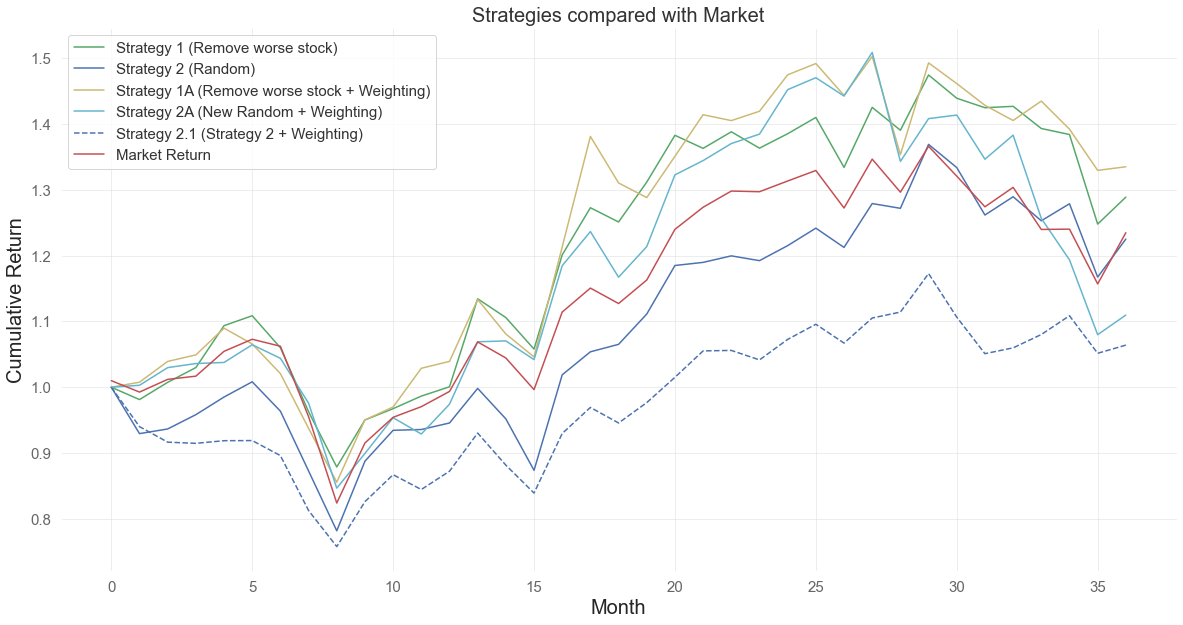

In [123]:
# Plot the market index and our portfolio performance, check if portfolio is better than market or not

''' Visualization '''

fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((1 + s1_portfolio['Return']).cumprod()[:-2], color = 'g')
plt.plot((1 + s2_portfolio['Return']).cumprod()[:-2], color = 'b')
plt.plot((1 + s1a_portfolio['Return']).cumprod()[:-2], color = 'y')
plt.plot((1 + s2a_portfolio['Return']).cumprod()[:-2], color = 'c')
plt.plot((1 + s21_portfolio['Return']).cumprod()[:-2], color = 'b', linestyle='dashed')
plt.plot((1 + mkt_index['Return'][mkt_start:].reset_index(drop = True)).cumprod()[:-2], color = 'r')
plt.title('Strategies compared with Market', fontsize = 20)
plt.ylabel('Cumulative Return', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Strategy 1 (Remove worse stock)', 'Strategy 2 (Random)', 'Strategy 1A (Remove worse stock + Weighting)', 'Strategy 2A (New Random + Weighting)', 'Strategy 2.1 (Strategy 2 + Weighting)', 'Market Return'], fontsize = 15)
#plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()

In [241]:
# Export html report of above 5 strategies using Quantstats library

qs_src = s1_export.copy() # Prevent modify the original data
qs_src.index = qs_src.index + pd.DateOffset(months=1) # Add 1 month to date field
qs.reports.html(qs_src['Return'][:-2], benchmark='^DJI', title='Strategy 1 vs DJI', output='', download_filename='s1_vs_dji.html')

In [242]:
qs_src = s2_export.copy()
qs_src.index = qs_src.index + pd.DateOffset(months=1)
qs.reports.html(qs_src['Return'][:-2], benchmark='^DJI', title='Strategy 2 vs DJI', output='', download_filename='s2_vs_dji.html')

In [243]:
qs_src = s1a_export.copy()
qs_src.index = qs_src.index + pd.DateOffset(months=1)
qs.reports.html(qs_src['Return'][:-2], benchmark='^DJI', title='Strategy 1A vs DJI', output='', download_filename='s1a_vs_dji.html')

In [244]:
qs_src = s2a_export.copy()
qs_src.index = qs_src.index + pd.DateOffset(months=1)
qs.reports.html(qs_src['Return'][:-2], benchmark='^DJI', title='Strategy 2A vs DJI', output='', download_filename='s2a_vs_dji.html')

In [245]:
qs_src = s21_export.copy()
qs_src.index = qs_src.index + pd.DateOffset(months=1)
qs.reports.html(qs_src['Return'][:-2], benchmark='^DJI', title='Strategy 2.1 vs DJI', output='', download_filename='s21_vs_dji.html')

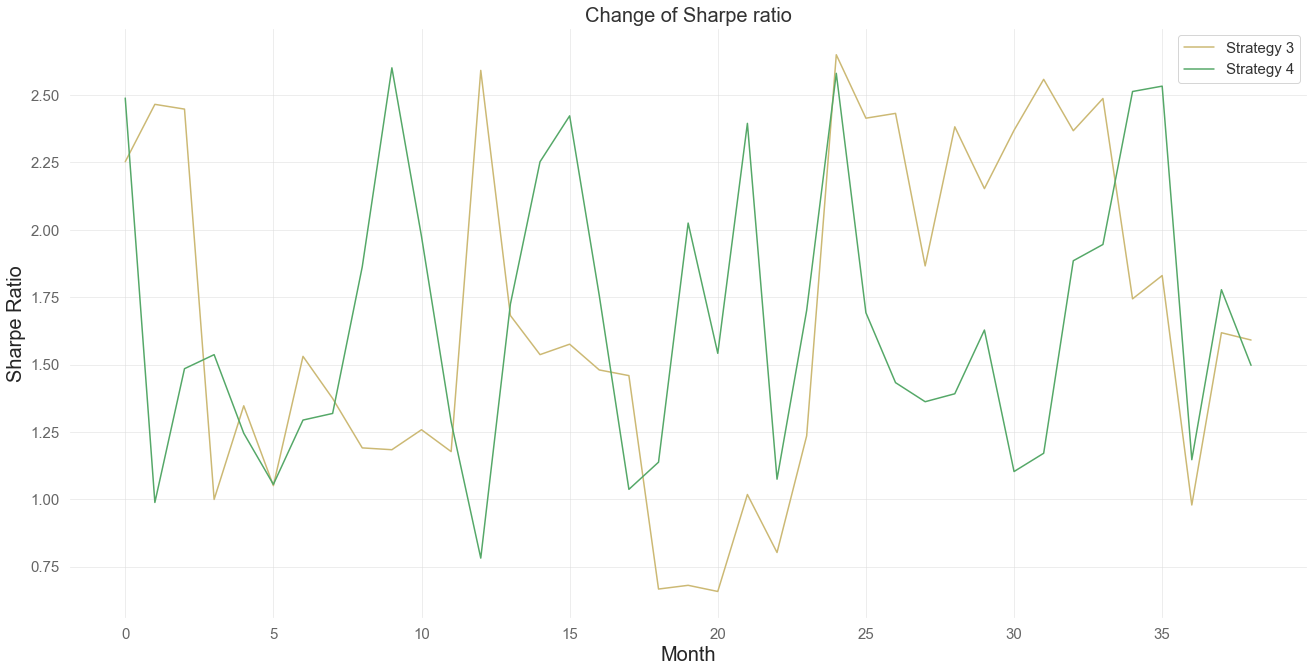

In [246]:
# Below all codes are for DEBUG, no need to run!!!
# For Strategy 3 and 4 - Plot Sharpe ratio 
fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((s1a_portfolio['sharpe']), color = 'y')
plt.plot((s2a_portfolio['sharpe']), color = 'g')
#plt.plot((1 + dji_index['Return'][2:].reset_index(drop = True)).cumprod(), color = 'r')
plt.title('Change of Sharpe ratio', fontsize = 20)
plt.ylabel('Sharpe Ratio', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Strategy 3', 'Strategy 4'], fontsize = 15)
plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()

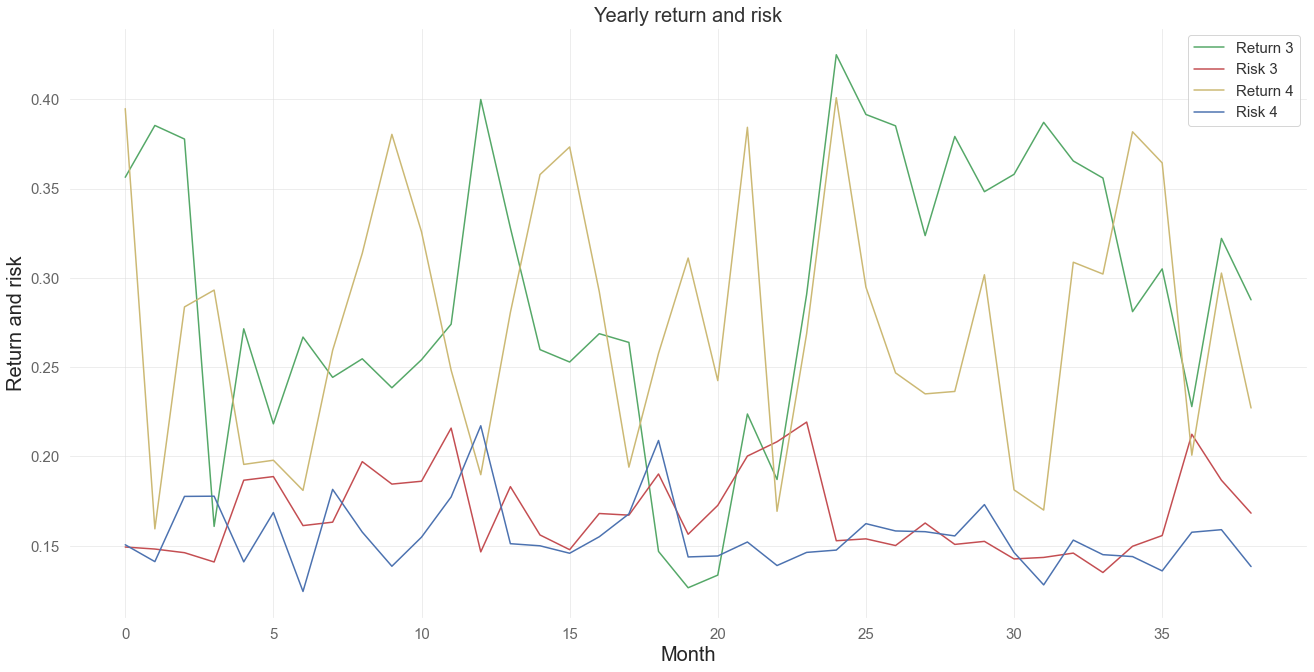

In [247]:
# For Strategy 3 and 4 - Plot Return and Risk
fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((s1a_portfolio['yr_return']), color = 'g')
plt.plot((s1a_portfolio['yr_risk']), color = 'r')
plt.plot((s2a_portfolio['yr_return']), color = 'y')
plt.plot((s2a_portfolio['yr_risk']), color = 'b')
#plt.plot((1 + dji_index['Return'][2:].reset_index(drop = True)).cumprod(), color = 'r')
plt.title('Yearly return and risk', fontsize = 20)
plt.ylabel('Return and risk', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Return 3','Risk 3', 'Return 4', 'Risk 4'], fontsize = 15)
plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()